In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *
from model_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


In [125]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(70.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]


orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1800):
    if ii % 50 == 0:
        times_observed_astrometry.append(ii)

t_1 =  times_observed_astrometry[-1]+1800
for ii in range(t_1, t_1+1800):
    if ii % 50 == 0:
        times_observed_astrometry.append(ii)      
        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    if ii % 50 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
        
    if add_data:
        times_observed_rv.append(ii)
        

n_planets = 2

sigma_rv = 0.1

sigma_theta = 0.05
sigma_rho = 0.001
parallax = 0.1



times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    parallax,
    orbit_params,
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
[rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results



In [126]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), sigma_theta)
rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), sigma_rho)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





finding RV model solutions


optimizing logp for variables: [logK, ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -3199454.955409542 -> -4940.641834799274
optimizing logp for variables: [logK, ecs, tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -4940.641834799274 -> 977.5655529082687
optimizing logp for variables: [logs, ecs, logK, logP, tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: 977.5655529082687 -> 987.9841438167899


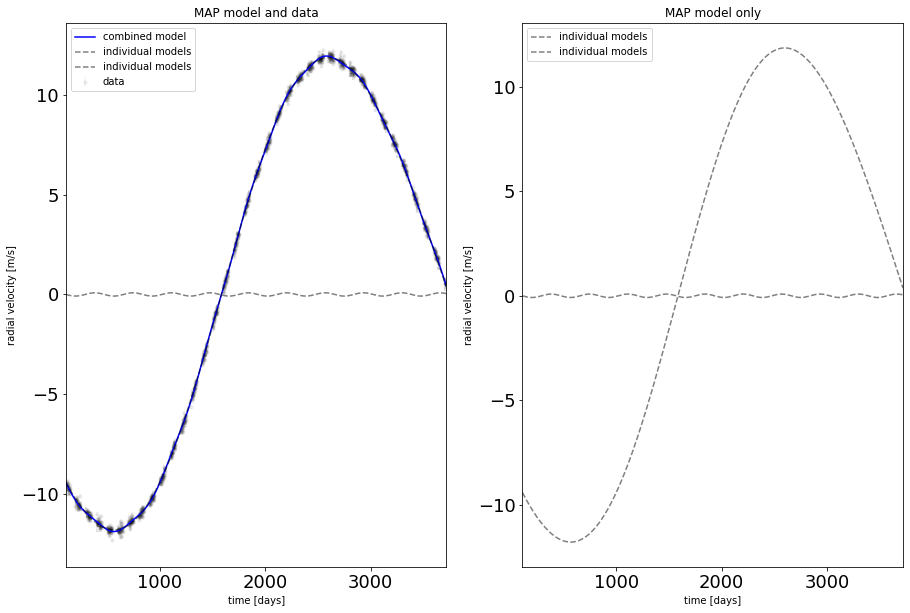

In [127]:

periods_guess = [360, 4330]
Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


print("finding RV model solutions")
rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1,2, figsize = [15,10])

ax[0].errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax[0].plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax[0].plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax[0].legend(fontsize=10)
ax[0].set_xlim(t_rv.min(), t_rv.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("MAP model and data")


ax[1].plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")
ax[1].legend(fontsize=10)
ax[1].set_xlim(t_rv.min(), t_rv.max())
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("radial velocity [m/s]")
ax[1].set_title("MAP model only")
plt.show()



In [128]:
print("finding joint model solutions")
parallax = 0.1 # arcsec
model, map_soln = model_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
                             rho_data, rho_err, theta_data, theta_err, parallax)



finding joint model solutions
[ 364.23163811 4324.12931015]
[ 0.08253301 11.82658099]
[2484.04234885 1627.1558125 ]
[1.40932194e-13 4.80981744e-02]
[-1.43888406 -1.50589359]


optimizing logp for variables: [sqrtm_sini, sqrtm_cosi]


message: Desired error not necessarily achieved due to precision loss.
logp: -3746085.366533096 -> -26960.338810949383
optimizing logp for variables: [phase]


message: Desired error not necessarily achieved due to precision loss.
logp: -26960.338810949383 -> -23930.909016047404
optimizing logp for variables: [ecs, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -23930.909016047404 -> -23930.909016047404
optimizing logp for variables: [phase, sqrtm_sini, sqrtm_cosi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -23930.909016047404 -> -22332.97143483591
optimizing logp for variables: [log_rv, log_theta_s, log_rho_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -22332.97143483591 -> -22332.97143483591


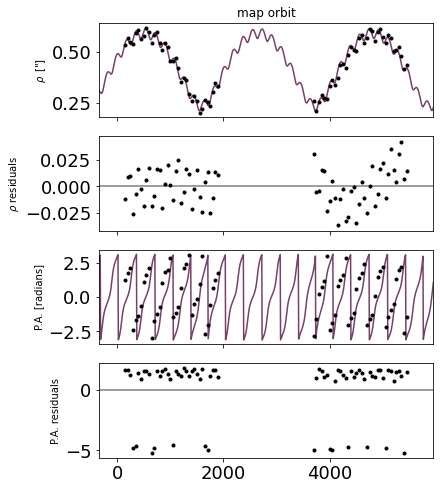

In [129]:


ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_model_pred"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
	x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_model_pred"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
	x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

plt.show()



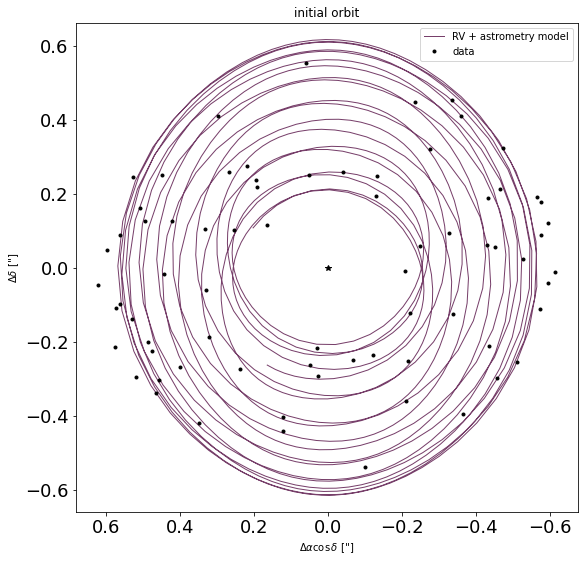

In [130]:


fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_model_pred"] * np.cos(map_soln["theta_model_pred"])  # X is north
ys = map_soln["rho_model_pred"] * np.sin(map_soln["theta_model_pred"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()



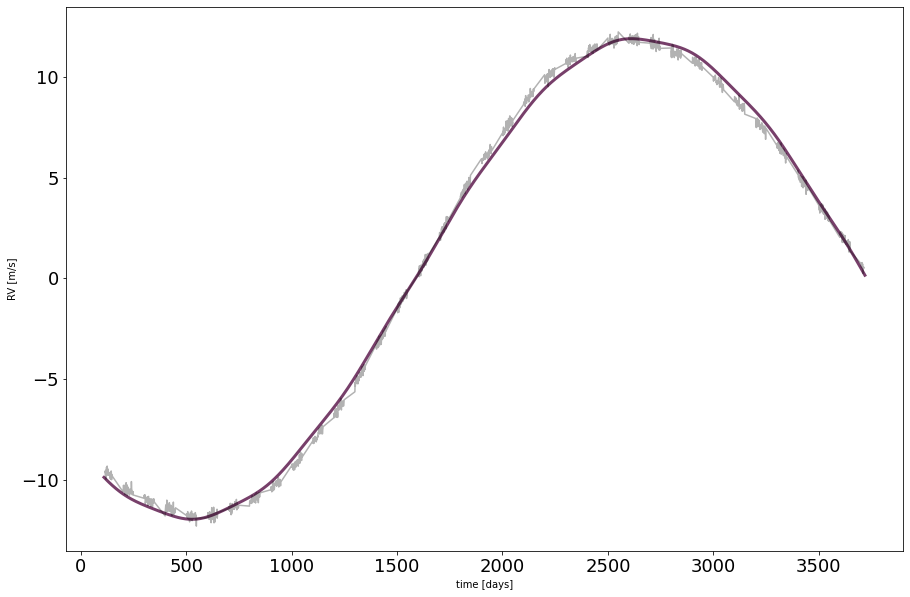

In [131]:
plt.figure(figsize=[15,10])
plt.plot(t_rv, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.plot(x_rv, y_rv, color='k', alpha=0.3)
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
plt.show()



In [86]:
# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=[Tper_earth, Tper_jup], period=[P_earth, P_jup], ecc=[e_earth, e_jup], 
    omega=[omega_earth, omega_jup], m_planet = [m_earth, m_jup], 
    Omega = [Omega_earth, Omega_jup], incl = [inclination_earth, inclination_jup])

# determine and print the star position at desired times
pos = theano.function([], orbit.get_star_position(x_astrometry))()
pos = tt.sum(pos, axis=-1)

x,y,z = pos.eval()




In [96]:
def DEC(z):
    return np.arcsin(z)

def RA(y, DEC):
    sin_ra = y/np.cos(DEC)
    print('here')
    if sin_ra.any() < -np.pi/2:
        print(hi)
        sin_ra += 2*np.pi
    print(sin_ra)
    print(np.arcsin(sin_ra))
    return np.arcsin(sin_ra)

In [97]:
dec = DEC(z)
ra = RA(y, dec)

here
[-1.14003600e+00 -1.12411545e+00 -1.11053806e+00 -1.09871974e+00
 -1.08812849e+00 -1.07836901e+00 -1.06922435e+00 -1.06060720e+00
 -1.05242896e+00 -1.04449069e+00 -1.03649634e+00 -1.02815749e+00
 -1.01930054e+00 -1.00991029e+00 -1.00004632e+00 -9.89619664e-01
 -9.78185274e-01 -9.64939905e-01 -9.48890384e-01 -9.29033306e-01
 -9.04424638e-01 -8.73959656e-01 -8.35625361e-01 -7.85287548e-01
 -7.15484084e-01 -6.14676701e-01 -4.67949172e-01 -2.62279721e-01
 -1.14815350e-04  2.85736603e-01  5.41557840e-01  7.30674668e-01
  8.52612229e-01  9.26301199e-01  9.70723515e-01  9.98555646e-01]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -1.42658575e+00
 -1.36153809e+00 -1.30521432e+00 -1.24970128e+00 -1.19179150e+00
 -1.13002918e+00 -1.06329105e+00 -9.89270271e-01 -9.03160428e-01
 -7.97316767e-01 -6

<ipython-input-96-1bc38163fca4>:10: RuntimeWarning: invalid value encountered in arcsin
  print(np.arcsin(sin_ra))
<ipython-input-96-1bc38163fca4>:11: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(sin_ra)


In [91]:
print(dec)
print(ra)

[-0.61250562 -0.5377825  -0.46352077 -0.38991226 -0.31689551 -0.24417198
 -0.17134382 -0.09813766 -0.02458673  0.04901369  0.12234239  0.19525935
  0.26787531  0.34049057  0.41340555  0.48667036  0.55998517  0.6328645
  0.70489619  0.7759084   0.84599399  0.91534732  0.98388257  1.05082442
  1.11457248  1.17281137  1.22262766  1.26062578  1.28326189  1.2876199
  1.27262881  1.2399308   1.19325747  1.13685133  1.07435611  1.00844047]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -1.42658575e+00
 -1.36153809e+00 -1.30521432e+00 -1.24970128e+00 -1.19179150e+00
 -1.13002918e+00 -1.06329105e+00 -9.89270271e-01 -9.03160428e-01
 -7.97316767e-01 -6.61976028e-01 -4.86968766e-01 -2.65383872e-01
 -1.14815350e-04  2.89774990e-01  5.72289113e-01  8.19309626e-01
  1.02096415e+00  1.18447450e+00  1.3282248